In [1]:
import numpy as np

In [2]:
!pip3 install packaage imutils

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.


In [238]:
import numpy as np
import os
import argparse
import cv2
from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer,Conv2D,Activation,MaxPool2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras 

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error


### Import and Transform the Data

In [173]:
from sklearn.utils import resample

def dataextractor(path,height=32,width=32):
    data_positive=[]
    data_negative=[]
    imagepaths = list(paths.list_images(path))
    for imagepath in imagepaths:
        
        cluster = imagepath.split(os.sep)[-2].split('_')[0]

        if cluster == 'negatives':
            data_negative.append(imagepath)
        else:
            data_positive.append(imagepath)

    negative_downsample = resample(data_negative,
             replace=True,
             n_samples=len(data_positive),
             random_state=42)
    
    imagepaths = data_positive + negative_downsample

    data=[]
    labels = []

    for imagepath in imagepaths:
        image = cv2.imread(imagepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image,(height,width),interpolation=cv2.INTER_AREA)
        image = img_to_array(image)
        label = imagepath.split(os.sep)[-2].split('_')[-1]
        
        label = int(label)
        labels.append(label)
        data.append(image)
    return np.array(data,dtype='float')/255.0,np.array(labels)
    # splitting the data into train and test

train_X,train_y =dataextractor('Train_dataset')
test_X,test_y = dataextractor('Test_dataset')

In [174]:
classes=2
input_shape = (32,32,1)

In [175]:
train_y = train_y.reshape((-1,1))
test_y = test_y.reshape((-1,1))
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(5854, 32, 32, 1)
(5854, 1)
(1526, 32, 32, 1)
(1526, 1)


### CNN LeNet - 5
- https://www.kaggle.com/code/ghousethanedar/smile-detection
- https://ai.stackexchange.com/questions/23692/how-much-overfitting-is-acceptable

In [176]:
def build_clf(learn_rate=0.01):
    sgd = SGD(lr=learn_rate)
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(32,32,1)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2))) #采样层

    model.add(Flatten()) #unflod to 1 dim
    model.add(Dense(64)) #Dense is set of node
    model.add(Activation('relu')) #relu save storage place
    model.add(Dropout(0.5)) # 是为了防止过度拟合问题出现，在训练时专门加入的层。该层在forward过程中随机drop out一系列的激活值，将其值改成0，减少过度拟合。该层使用下，使得网络在随机去掉一些激活值后依然能够有正确的分类等结果，即对不同有更好的适应性。
    model.add(Dense(1)) # the reason of dense (1) is because this question is 0,1 classifier
    model.add(Activation('sigmoid')) 

    model.compile(loss='binary_crossentropy',
                optimizer= sgd,
                metrics=['accuracy'])
    return model

In [177]:
epochs = [5,10,20]
learn_rate = [0.01,0.05,0.1]
random_grid = {'epochs': epochs,
               'learn_rate': learn_rate}

model=KerasClassifier(build_fn=build_clf)

scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)
        }

grid_search_cv=RandomizedSearchCV(model,random_grid,verbose=1,cv=3,scoring=scorers,refit="precision_score",return_train_score = True)
grid_search_cv.fit(train_X,train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Epoch 1/5
122/122 [==============================] - 2s 18ms/step - loss: 0.6147 - accuracy: 0.7473
Epoch 2/5
122/122 [==============================] - 2s 16ms/step - loss: 0.5746 - accuracy: 0.7501
Epoch 3/5
122/122 [==============================] - 2s 15ms/step - loss: 0.5689 - accuracy: 0.7501
Epoch 4/5
122/122 [==============================] - 2s 19ms/step - loss: 0.5695 - accuracy: 0.7501
Epoch 5/5
122/122 [==============================] - 2s 20ms/step - loss: 0.5693 - accuracy: 0.7501
Epoch 1/5
122/122 [==============================] - 2s 19ms/step - loss: 0.6930 - accuracy: 0.5019
Epoch 2/5
122/122 [==============================] - 2s 20ms/step - loss: 0.6929 - accuracy: 0.5140
Epoch 3/5
122/122 [==============================] - 2s 18ms/step - loss: 0.6922 - accuracy: 0.5155
Epoch 4/5
122/122 [==============================] - 2s 18ms/step - loss: 0.6926 - accuracy: 0.5263
Epoch 5/5
122/122 [=====================

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe8aed80610>,
                   param_distributions={'epochs': [5, 10, 20],
                                        'learn_rate': [0.01, 0.05, 0.1]},
                   refit='precision_score', return_train_score=True,
                   scoring={'accuracy_score': make_scorer(accuracy_score),
                            'precision_score': make_scorer(precision_score),
                            'recall_score': make_scorer(recall_score)},
                   verbose=1)

In [178]:
grid_search_cv.best_params_

{'learn_rate': 0.1, 'epochs': 20}

Text(0.5, 1.0, 'Cross-validation for CNN')

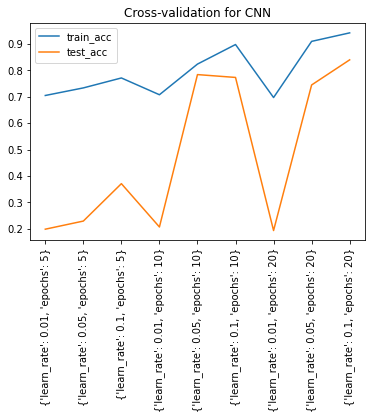

In [245]:
x_array = [1,2,3,4,5,6,7,8,9]
mean_train_accuracy_score = grid_search_cv.cv_results_['mean_train_accuracy_score']
mean_test_accuracy_score = grid_search_cv.cv_results_['mean_test_accuracy_score']
labels = grid_search_cv.cv_results_['params']

fig = plt.figure()
ax = plt.axes()
line1,=ax.plot(x_array, mean_train_accuracy_score, label='train_acc')
line2,=ax.plot(x_array, mean_test_accuracy_score, label='test_acc')
ax.legend(handles=[line1, line2])
ax.set_xticks(x_array)
ax.set_xticklabels(labels)
plt.xticks(rotation=90)
plt.title("Cross-validation for CNN")

In [246]:
print(mean_train_accuracy_score)
print(mean_test_accuracy_score)

[0.70482109 0.73351696 0.7711803  0.70763943 0.82371409 0.89776263
 0.69704929 0.90971878 0.94192029]
[0.19853067 0.22928413 0.3709209  0.20690244 0.78392561 0.77315271
 0.19340509 0.74463679 0.8397796 ]


In [205]:
grid_search_cv.cv_results_['std_test_accuracy_score'][4]

0.07187782340737268

In [214]:
cnn_model = build_clf(0.05)
cnn_model.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=10,batch_size=32)

Epoch 1/10
183/183 [==============================] - 3s 17ms/step - loss: 0.6921 - accuracy: 0.5159 - val_loss: 0.6904 - val_accuracy: 0.5321
Epoch 2/10
183/183 [==============================] - 4s 19ms/step - loss: 0.6893 - accuracy: 0.5557 - val_loss: 0.6864 - val_accuracy: 0.6514
Epoch 3/10
183/183 [==============================] - 4s 20ms/step - loss: 0.6821 - accuracy: 0.5772 - val_loss: 0.6821 - val_accuracy: 0.5085
Epoch 4/10
183/183 [==============================] - 3s 17ms/step - loss: 0.6535 - accuracy: 0.6513 - val_loss: 0.6093 - val_accuracy: 0.7333
Epoch 5/10
183/183 [==============================] - 3s 17ms/step - loss: 0.5521 - accuracy: 0.7414 - val_loss: 0.4835 - val_accuracy: 0.7798
Epoch 6/10
183/183 [==============================] - 3s 19ms/step - loss: 0.4515 - accuracy: 0.8008 - val_loss: 0.4237 - val_accuracy: 0.8178
Epoch 7/10
183/183 [==============================] - 4s 21ms/step - loss: 0.3954 - accuracy: 0.8340 - val_loss: 0.3989 - val_accuracy: 0.8316

In [235]:
from sklearn.metrics import classification_report
predictions = cnn_model.predict(test_X, batch_size=64)
predicted_val = [int(round(p[0])) for p in predictions]
print("classification report ",classification_report(test_y,predicted_val,target_names=['smiling','not_smiling']))

classification report                precision    recall  f1-score   support

     smiling       0.94      0.67      0.78       763
 not_smiling       0.74      0.96      0.84       763

    accuracy                           0.81      1526
   macro avg       0.84      0.81      0.81      1526
weighted avg       0.84      0.81      0.81      1526



In [237]:
predictions = cnn_model.predict(train_X, batch_size=64)
predicted_val = [int(round(p[0])) for p in predictions]
print("classification report ",classification_report(train_y,predicted_val,target_names=['smiling','not_smiling']))

classification report                precision    recall  f1-score   support

     smiling       0.94      0.76      0.84      2927
 not_smiling       0.80      0.95      0.87      2927

    accuracy                           0.86      5854
   macro avg       0.87      0.86      0.86      5854
weighted avg       0.87      0.86      0.86      5854



In [239]:
CNN_test_rmse = mean_squared_error(test_y, cnn_model.predict(test_X), squared=True)
CNN_train_rmse = mean_squared_error(train_y, cnn_model.predict(train_X), squared=True)
print(CNN_test_rmse)
print(CNN_train_rmse)

0.14198996213934062
0.10166423640937337


### Random Forest
https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn

Pass x_train2 to fit() function as it is the reshaped 2D array of the images and sklearn needs a 2D array as input here. Do this while fitting for all the models as they are all implemented using sklearn

In [217]:
nsamples, nx, ny, nrgb = train_X.shape
train_X_RF = train_X.reshape((nsamples,nx*ny*nrgb))
nsamples, nx, ny, nrgb = test_X.shape
test_X_RF = test_X.reshape((nsamples,nx*ny*nrgb))

In [218]:
print(train_X_RF.shape)
print(train_y.shape)
print(test_X_RF.shape)
print(test_y.shape)

(5854, 1024)
(5854, 1)
(1526, 1024)
(1526, 1)


In [219]:
# Number of trees in random forest
n_estimators = [100,500,1000]
# Maximum number of levels in tree
max_depth = [10,50,100]
min_samples_leaf = [50,100]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               "min_samples_leaf":min_samples_leaf}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42,return_train_score = True)# Fit the random search model
rf_random.fit(train_X_RF,train_y)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': [10, 50, 100],
                                        'min_samples_leaf': [50, 100],
                                        'n_estimators': [100, 500, 1000]},
                   random_state=42, return_train_score=True)

In [220]:
rf_random.best_params_

{'n_estimators': 1000, 'min_samples_leaf': 50, 'max_depth': 100}

Text(0.5, 1.0, 'Cross-validation for RF')

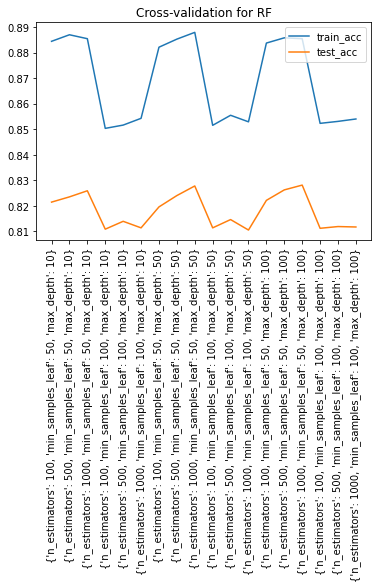

In [247]:
x_array = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
mean_train_accuracy_score = rf_random.cv_results_['mean_train_score']
mean_test_accuracy_score = rf_random.cv_results_['mean_test_score']
labels = rf_random.cv_results_['params']

fig = plt.figure()
ax = plt.axes()
line1,=ax.plot(x_array, mean_train_accuracy_score, label='train_acc')
line2,=ax.plot(x_array, mean_test_accuracy_score, label='test_acc')
ax.legend(handles=[line1, line2])
ax.set_xticks(x_array)
ax.set_xticklabels(labels)
plt.xticks(rotation=90)
plt.title("Cross-validation for RF")

In [248]:
print(mean_train_accuracy_score)
print(mean_test_accuracy_score)

[0.88443792 0.88700056 0.8854631  0.85035914 0.85164036 0.85428807
 0.88213198 0.88529225 0.88793992 0.85155443 0.85548367 0.85292158
 0.88375489 0.88580468 0.88546295 0.85232384 0.85309237 0.85403184]
[0.82148893 0.82354003 0.82593144 0.81089826 0.8139736  0.81141152
 0.81961104 0.82405285 0.82781047 0.8114123  0.81465763 0.81055664
 0.82217295 0.82627271 0.82815156 0.81123935 0.81192372 0.81175331]


In [223]:
rf_random.cv_results_['std_test_score'][14]

0.007968815535333521

In [224]:
from sklearn.ensemble import RandomForestClassifier
model_RF=RandomForestClassifier(n_estimators= 1000, max_depth= 100,min_samples_leaf = 50)
model_RF.fit(train_X_RF,train_y)
y_pred=model_RF.predict(test_X_RF)
y_pred

array([1, 0, 0, ..., 1, 1, 0])

In [225]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
accuracy_score(y_pred,test_y)
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       691
           1       0.86      0.78      0.82       835

    accuracy                           0.81      1526
   macro avg       0.81      0.81      0.81      1526
weighted avg       0.81      0.81      0.81      1526



In [240]:
y_pred_train = model_RF.predict(train_X_RF)
print(classification_report(y_pred_train,train_y))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2966
           1       0.88      0.89      0.89      2888

    accuracy                           0.89      5854
   macro avg       0.89      0.89      0.89      5854
weighted avg       0.89      0.89      0.89      5854



In [242]:
RF_test_rmse = mean_squared_error(test_y, model_RF.predict(test_X_RF), squared=True)
RF_train_rmse = mean_squared_error(train_y, model_RF.predict(train_X_RF), squared=True)
print(RF_test_rmse)
print(RF_train_rmse)

0.1913499344692005
0.1105227195080287


### Gradient Boosting
- https://www.baeldung.com/cs/gradient-boosting-trees-vs-random-forests
- https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae
- https://www.analyticsvidhya.com/blog/2020/02/4-boosting-algorithms-machine-learning/#:~:text=1.-,Gradient%20Boosting%20Machine%20(GBM),boosting%20machine%20are%20decision%20trees. Why GBM

In [227]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
#random search light gbm
gb = GradientBoostingClassifier()
gb_parameters = { 'n_estimators': [10, 50, 100],
                  'learning_rate': [0.01,0.05,0.1],
                  'max_depth' : [1,2]}

gb_search = RandomizedSearchCV(gb,param_distributions=gb_parameters,scoring='roc_auc',cv=3,random_state = 42,return_train_score = True)
gb_search.fit(train_X_RF, train_y)

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [1, 2],
                                        'n_estimators': [10, 50, 100]},
                   random_state=42, return_train_score=True, scoring='roc_auc')

In [228]:
gb_search.best_params_

{'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05}

Text(0.5, 1.0, 'Cross-validation for GB')

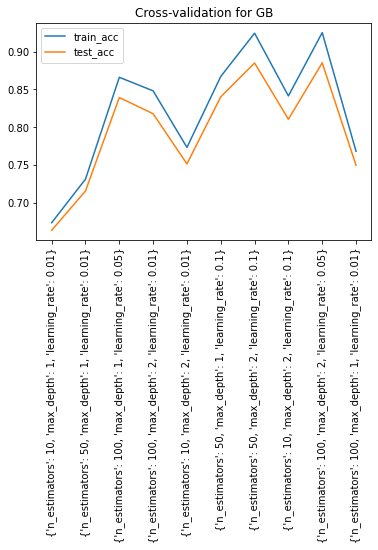

In [249]:
x_array = [1,2,3,4,5,6,7,8,9,10]
mean_train_accuracy_score = gb_search.cv_results_['mean_train_score']
mean_test_accuracy_score = gb_search.cv_results_['mean_test_score']
labels = gb_search.cv_results_['params']

fig = plt.figure()
ax = plt.axes()
line1,=ax.plot(x_array, mean_train_accuracy_score, label='train_acc')
line2,=ax.plot(x_array, mean_test_accuracy_score, label='test_acc')
ax.legend(handles=[line1, line2])
ax.set_xticks(x_array)
ax.set_xticklabels(labels)
plt.xticks(rotation=90)
plt.title("Cross-validation for GB")

In [250]:
print(mean_train_accuracy_score)
print(mean_test_accuracy_score)

[0.67336898 0.73107701 0.86597138 0.84802973 0.77309307 0.86710217
 0.9243824  0.84127885 0.92515909 0.76793781]
[0.66331114 0.71539962 0.83916077 0.81771294 0.75123089 0.84009302
 0.88495    0.81041901 0.88514756 0.74946658]


In [234]:
gb_search.cv_results_['std_test_score'][8]

0.005779850383416602

In [231]:
gradient_booster = GradientBoostingClassifier(n_estimators = 100,learning_rate=0.05,max_depth = 2)
gradient_booster.fit(train_X_RF,train_y)
print(classification_report(test_y,gradient_booster.predict(test_X_RF)))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       763
           1       0.75      0.84      0.80       763

    accuracy                           0.78      1526
   macro avg       0.79      0.78      0.78      1526
weighted avg       0.79      0.78      0.78      1526



In [232]:
print(classification_report(train_y,gradient_booster.predict(train_X_RF)))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2927
           1       0.83      0.85      0.84      2927

    accuracy                           0.84      5854
   macro avg       0.84      0.84      0.84      5854
weighted avg       0.84      0.84      0.84      5854



In [243]:
GB_test_rmse = mean_squared_error(test_y, gradient_booster.predict(test_X_RF), squared=True)
GB_train_rmse = mean_squared_error(train_y, gradient_booster.predict(train_X_RF), squared=True)
print(GB_test_rmse)
print(GB_train_rmse)

0.21559633027522937
0.15937820293816193
